In [42]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
import gc
from haversine import haversine

def csv_to_parquet(csv_path, save_name):
    df = pd.read_csv(csv_path)
    df.to_parquet(f'./{save_name}.parquet')
    del df
    gc.collect()
    print(save_name, 'Done.')
    
csv_to_parquet('input/train.csv', 'train')
csv_to_parquet('input/test.csv', 'test')    

### data info 전환

In [4]:
#data_info = pd.read_csv('input/data_info.csv')

In [6]:
#data_info.to_excel('data_info.xlsx', encoding='utf-8-sig')

In [66]:
# https://data.kma.go.kr/data/grnd/selectAsosRltmList.do?pgmNo=36
weather = pd.read_csv('input/weather.csv', encoding='cp949')
weather.shape

(5948, 38)

In [70]:
weather.describe(include="all")

,지점,지점명,일시,기온(°C),기온 QC플래그,강수량(mm),강수량 QC플래그,풍속(m/s),풍속 QC플래그,풍향(16방위),...,최저운고(100m ),시정(10m),지면상태(지면상태코드),현상번호(국내식),지면온도(°C),지면온도 QC플래그,5cm 지중온도(°C),10cm 지중온도(°C),20cm 지중온도(°C),30cm 지중온도(°C)
count,5948.000000,5948,5948,5948.000000,0.0,673.000000,1336.0,5946.000000,2.0,5946.000000,...,4250.000000,5948.000000,0.0,448.000000,5947.000000,1.0,1487.000000,1487.000000,1487.000000,1487.000000
unique,NaN,4,1487,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,고산,2022-07-26 04:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,1487,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,186.500000,NaN,NaN,27.691174,NaN,2.480981,9.0,3.373058,9.0,188.847965,...,12.063294,2264.493107,NaN,1088.437500,31.126400,9.0,30.442098,30.558305,30.656624,30.389038
std,2.061726,NaN,NaN,2.282626,NaN,6.116128,0.0,2.166737,0.0,96.102875,...,14.999584,1061.302610,NaN,12786.938356,5.891328,NaN,1.726362,1.630628,1.238528,0.901797
min,184.000000,NaN,NaN,19.500000,NaN,0.000000,9.0,0.000000,9.0,0.000000,...,1.000000,29.000000,NaN,1.000000,18.800000,9.0,26.200000,26.500000,27.600000,28.600000
25%,184.750000,NaN,NaN,26.300000,NaN,0.000000,9.0,1.700000,9.0,110.000000,...,4.000000,1948.000000,NaN,1.000000,27.100000,9.0,29.200000,29.400000,29.700000,29.700000
50%,186.500000,NaN,NaN,27.600000,NaN,0.200000,9.0,3.000000,9.0,200.000000,...,7.000000,2000.000000,NaN,1.000000,29.300000,9.0,30.300000,30.400000,30.700000,30.300000
75%,188.250000,NaN,NaN,28.900000,NaN,2.000000,9.0,4.700000,9.0,250.000000,...,11.000000,2000.000000,NaN,19.000000,33.900000,9.0,31.700000,31.700000,31.600000,31.100000


In [72]:
weather.columns

Index(['지점', '지점명', '일시', '기온(°C)', '기온 QC플래그', '강수량(mm)', '강수량 QC플래그',
       '풍속(m/s)', '풍속 QC플래그', '풍향(16방위)', '풍향 QC플래그', '습도(%)', '습도 QC플래그',
       '증기압(hPa)', '이슬점온도(°C)', '현지기압(hPa)', '현지기압 QC플래그', '해면기압(hPa)',
       '해면기압 QC플래그', '일조(hr)', '일조 QC플래그', '일사(MJ/m2)', '일사 QC플래그', '적설(cm)',
       '3시간신적설(cm)', '전운량(10분위)', '중하층운량(10분위)', '운형(운형약어)', '최저운고(100m )',
       '시정(10m)', '지면상태(지면상태코드)', '현상번호(국내식)', '지면온도(°C)', '지면온도 QC플래그',
       '5cm 지중온도(°C)', '10cm 지중온도(°C)', '20cm 지중온도(°C)', '30cm 지중온도(°C)'],
      dtype='object')

In [71]:
weather['지점명'].value_counts()

고산     1487
서귀포    1487
성산     1487
제주     1487
Name: 지점명, dtype: int64

In [73]:
weather['일시'].value_counts().sort_values()

2022-07-26 04:00    4
2022-08-01 10:00    4
2022-08-31 03:00    4
2022-08-20 06:00    4
2022-08-01 21:00    4
                   ..
2022-08-27 03:00    4
2022-07-23 22:00    4
2022-08-29 21:00    4
2022-07-17 03:00    4
2022-07-06 07:00    4
Name: 일시, Length: 1487, dtype: int64

In [75]:
weather[weather['일시'] == '2022-07-26 04:00'].T

,603,2090,3577,5064
지점,184,185,188,189
지점명,제주,고산,성산,서귀포
일시,2022-07-26 04:00,2022-07-26 04:00,2022-07-26 04:00,2022-07-26 04:00
기온(°C),23.5,23.9,21.7,23.2
기온 QC플래그,NaN,NaN,NaN,NaN
강수량(mm),NaN,NaN,NaN,NaN
강수량 QC플래그,NaN,NaN,NaN,NaN
풍속(m/s),1.5,2,1.1,1.7
풍속 QC플래그,NaN,NaN,NaN,NaN
풍향(16방위),180,340,20,360


In [ ]:
weather.groupby(['일시','지점명']).agg({'기온(°C)':'m'})

## data load

In [8]:
#!pip install pyarrow

train Done.
test Done.


In [48]:
train = pd.read_parquet('./train.parquet')
test = pd.read_parquet('./test.parquet')

## EDA

In [10]:
train.shape, test.shape

((4701217, 23), (291241, 22))

In [11]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4701217 entries, 0 to 4701216
Data columns (total 23 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   id                     object 
 1   base_date              int64  
 2   day_of_week            object 
 3   base_hour              int64  
 4   lane_count             int64  
 5   road_rating            int64  
 6   road_name              object 
 7   multi_linked           int64  
 8   connect_code           int64  
 9   maximum_speed_limit    float64
 10  vehicle_restricted     float64
 11  weight_restricted      float64
 12  height_restricted      float64
 13  road_type              int64  
 14  start_node_name        object 
 15  start_latitude         float64
 16  start_longitude        float64
 17  start_turn_restricted  object 
 18  end_node_name          object 
 19  end_latitude           float64
 20  end_longitude          float64
 21  end_turn_restricted    object 
 22  target            

In [13]:
train.isna().sum().sum(), test.isna().sum().sum()

(0, 0)

In [16]:
train.describe(include="all").T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
id,4701217,4701217,TRAIN_0366498,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
base_date,4.70122e+06,NaN,NaN,NaN,2.02167e+07,4555.71,2.02109e+07,2.02111e+07,2.02201e+07,2.02205e+07,2.02207e+07
day_of_week,4701217,7,금,684024,NaN,NaN,NaN,NaN,NaN,NaN,NaN
base_hour,4.70122e+06,NaN,NaN,NaN,11.9282,6.72209,0,6,12,18,23
lane_count,4.70122e+06,NaN,NaN,NaN,1.83665,0.687751,1,1,2,2,3
road_rating,4.70122e+06,NaN,NaN,NaN,104.958,1.84011,103,103,106,107,107
road_name,4701217,61,일반국도12호선,1046092,NaN,NaN,NaN,NaN,NaN,NaN,NaN
multi_linked,4.70122e+06,NaN,NaN,NaN,0.00047626,0.0218182,0,0,0,0,1
connect_code,4.70122e+06,NaN,NaN,NaN,0.266022,5.22776,0,0,0,0,103
maximum_speed_limit,4.70122e+06,NaN,NaN,NaN,61.2533,12.1335,30,50,60,70,80


In [15]:
train[:3]

,id,base_date,day_of_week,base_hour,lane_count,road_rating,road_name,multi_linked,connect_code,maximum_speed_limit,...,road_type,start_node_name,start_latitude,start_longitude,start_turn_restricted,end_node_name,end_latitude,end_longitude,end_turn_restricted,target
0,TRAIN_0000000,20220623,목,17,1,106,지방도1112호선,0,0,60.0,...,3,제3교래교,33.427747,126.662612,없음,제3교래교,33.427749,126.662335,없음,52.0
1,TRAIN_0000001,20220728,목,21,2,103,일반국도11호선,0,0,60.0,...,0,광양사거리,33.500730,126.529107,있음,KAL사거리,33.504811,126.526240,없음,30.0
2,TRAIN_0000002,20211010,일,7,2,103,일반국도16호선,0,0,80.0,...,0,창고천교,33.279145,126.368598,없음,상창육교,33.280072,126.362147,없음,61.0


In [23]:
# datetime
train['base_date'] = pd.to_datetime(train['base_date'], format='%Y%m%d')
test['base_date'] = pd.to_datetime(test['base_date'], format='%Y%m%d')

In [10]:
train['base_date'].min(), train['base_date'].max()

(Timestamp('2021-09-01 00:00:00'), Timestamp('2022-07-31 00:00:00'))

In [12]:
test['base_date'].min(), test['base_date'].max()

(Timestamp('2022-08-01 00:00:00'), Timestamp('2022-08-31 00:00:00'))

## 6월로 7월 예측

In [50]:
train['base_date'] = pd.to_datetime(train['base_date'], format='%Y%m%d')
train07 = train[train['base_date'].dt.strftime('%Y%m') == '202207']
train07.shape

(274695, 23)

In [31]:
test.shape

(291241, 22)

In [32]:
train.groupby(['yyyymm']).agg({'target':['min','max','mean', 'count']})

target                          
          min    max       mean   count
yyyymm                                 
202109    1.0   88.0  43.694340  570909
202110    1.0  103.0  43.495717  537916
202111    1.0   88.0  43.728215  120978
202112    2.0  112.0  43.030021  616511
202201    1.0   88.0  43.033130  569884
202202    1.0   93.0  43.256182  550807
202203    1.0   88.0  43.548673  505671
202205    1.0   98.0  42.639328  463709
202206    1.0   88.0  42.614157  490137
202207    2.0  113.0  36.282302  274695

In [59]:
display(train07['start_latitude'].value_counts().sort_values())
display(test['start_latitude'].value_counts().sort_values())

33.348828       1
33.375043       1
33.476199       1
33.345240       1
33.350271       1
             ... 
33.504059    2065
33.507349    2067
33.500330    2068
33.465863    2068
33.248633    2601
Name: start_latitude, Length: 514, dtype: int64

33.419828       7
33.408913       7
33.435941       7
33.420435       7
33.345240       7
             ... 
33.249029    2190
33.500330    2210
33.507349    2215
33.465863    2217
33.248633    2747
Name: start_latitude, Length: 294, dtype: int64

In [57]:
display(train07['start_latitude'].value_counts().sort_index())
display(test['start_latitude'].value_counts().sort_index())

33.243432     677
33.244601     687
33.244871    1370
33.244882    1313
33.245150    1370
             ... 
33.550675       1
33.551585       1
33.553525       1
33.554302       2
33.555316       1
Name: start_latitude, Length: 514, dtype: int64

33.243432     693
33.244601     715
33.244871    1419
33.244882    1358
33.245150    1420
             ... 
33.521098    1457
33.521264     726
33.521323     733
33.521329    1462
33.521399    1407
Name: start_latitude, Length: 294, dtype: int64

In [44]:
train07.columns

Index(['id', 'base_date', 'day_of_week', 'base_hour', 'lane_count',
       'road_rating', 'road_name', 'multi_linked', 'connect_code',
       'maximum_speed_limit', 'vehicle_restricted', 'weight_restricted',
       'height_restricted', 'road_type', 'start_node_name', 'start_latitude',
       'start_longitude', 'start_turn_restricted', 'end_node_name',
       'end_latitude', 'end_longitude', 'end_turn_restricted', 'target',
       'yyyymm'],
      dtype='object')

In [51]:
# label encoding 
str_col = ['road_name']
for i in str_col:
    le = LabelEncoder()
    le=le.fit(train07[i])
    train07[i]=le.transform(train07[i])
    
    for label in np.unique(test[i]):
        if label not in le.classes_: 
            le.classes_ = np.append(le.classes_, label)
    test[i]=le.transform(test[i])

C:\Users\okso6\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [54]:
train07[['weight_restricted','target']].corr()

,weight_restricted,target
weight_restricted,1.000000,0.333178
target,0.333178,1.000000


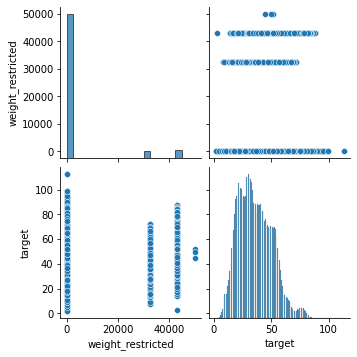

In [55]:
sns.pairplot(train07[['weight_restricted','target']])

In [29]:
# one-hot
cols = ['day_of_week','connect_code','road_type', 'start_turn_restricted', 'end_turn_restricted', 'road_name']
train = pd.get_dummies(train, prefix_sep='_', sparse=False, drop_first=True, columns = cols)
test = pd.get_dummies(test, prefix_sep='_', sparse=False, drop_first=True, columns = cols)

In [ ]:
# del 
del_cols = ['height_restricted','vehicle_restricted', 'start_node_name', 'end_node_name']
train = train.drop(del_cols, axis=1)
test = test.drop(del_cols, axis=1)

In [5]:
train['road_rating'].value_counts()

103    2159511
107    1582214
106     959492
Name: road_rating, dtype: int64

In [31]:
train['multi_linked'].value_counts()

0    4698978
1       2239
Name: multi_linked, dtype: int64

In [4]:
display(train['connect_code'].value_counts())
display(test['connect_code'].value_counts())

0      4689075
103      12142
Name: connect_code, dtype: int64

0    291241
Name: connect_code, dtype: int64

In [36]:
train['maximum_speed_limit'].value_counts()

60.0    1665573
50.0    1103682
70.0     995077
80.0     700334
30.0     229761
40.0       6790
Name: maximum_speed_limit, dtype: int64

In [6]:
display(train['weight_restricted'].value_counts())
display(test['weight_restricted'].value_counts())

0.0        4032874
43200.0     410361
32400.0     239305
50000.0      18677
Name: weight_restricted, dtype: int64

0.0        263267
43200.0     14527
32400.0     13428
50000.0        19
Name: weight_restricted, dtype: int64

In [39]:
train['height_restricted'].value_counts()
test['height_restricted'].value_counts()

0.0    291241
Name: height_restricted, dtype: int64

In [43]:
train['road_type'].value_counts()

0    3737117
3     964100
Name: road_type, dtype: int64

In [48]:
train['start_turn_restricted'].value_counts()

없음    4239701
있음     461516
Name: start_turn_restricted, dtype: int64

In [68]:
# 위경도로 거리 도출
train["distance"] = train[["start_latitude", "start_longitude", "end_latitude", "end_longitude"]].apply(lambda x: haversine((x[0], x[1]), (x[2], x[3])), axis="columns")
test["distance"] = test[["start_latitude", "start_longitude", "end_latitude", "end_longitude"]].apply(lambda x: haversine((x[0], x[1]), (x[2], x[3])), axis="columns")

In [69]:
train['road_name'].value_counts()

일반국도12호선    1046092
-            569463
일반국도16호선     554510
일반국도95호선     248181
일반국도11호선     215701
             ...   
애원로            7718
아봉로            7342
남조로            6813
호서중앙로          2819
호근로             587
Name: road_name, Length: 61, dtype: int64

In [70]:
train['start_node_name'].value_counts()

고성교차로              42169
산신주유소              29386
미수2교               26635
영주교                24381
봉개교 시종점            24290
                   ...  
외산리사무소               934
와산리                  881
성미가든                 788
서귀포시 호근동 1838-4      744
CU서귀호근로점             744
Name: start_node_name, Length: 487, dtype: int64

In [72]:
train['vehicle_restricted'].value_counts()

0.0    4701217
Name: vehicle_restricted, dtype: int64

## 데이터 전처리

In [9]:
str_col = ['day_of_week','start_turn_restricted','end_turn_restricted']
for i in str_col:
    le = LabelEncoder()
    le=le.fit(train[i])
    train[i]=le.transform(train[i])
    
    for label in np.unique(test[i]):
        if label not in le.classes_: 
            le.classes_ = np.append(le.classes_, label)
    test[i]=le.transform(test[i])

In [10]:
y_train = train['target'] 

X_train = train.drop(['id','base_date', 'target','road_name', 'start_node_name', 'end_node_name','vehicle_restricted'], axis=1)

test = test.drop(['id','base_date', 'road_name', 'start_node_name', 'end_node_name','vehicle_restricted'], axis=1)

print(X_train.shape)
print(y_train.shape)
print(test.shape)

(4701217, 16)
(4701217,)
(291241, 16)


## 모델링

In [11]:
LR = lgb.LGBMRegressor(random_state=42).fit(X_train, y_train)

## 예측

In [12]:
pred = LR.predict(test)

## 제출

In [14]:
sample_submission = pd.read_csv('input/sample_submission.csv')

In [15]:
sample_submission['target'] = pred
sample_submission.to_csv("output/submit.csv", index = False)